In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [49]:
# Załadowanie danych z pliku CSV, z określeniem separatora jako średnik
df = pd.read_csv("winequality-white.csv", sep=';')

In [50]:
for column in df.columns:
    try:
        # Usuwanie niepożądanych znaków i konwersja na float
        df[column] = df[column].replace('[^0-9.]', '', regex=True).astype(float)
    except AttributeError:
        # Jeśli kolumna nie jest typu string, nie wykonujemy żadnych działań
        continue


In [51]:
data_cleaned = df.copy()

for column in data_cleaned.select_dtypes(include=[float, int]).columns:
    Q1 = data_cleaned[column].quantile(0.25)
    Q3 = data_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Usuwanie wierszy z wartościami odstającymi
    data_cleaned = data_cleaned.drop(data_cleaned.loc[data_cleaned[column] > (Q3 + 1.5 * IQR)].index)
    data_cleaned = data_cleaned.drop(data_cleaned.loc[data_cleaned[column] < (Q1 - 1.5 * IQR)].index)

In [52]:
# Standaryzacja zmiennych
scaler = MinMaxScaler()
numerical_columns = data_cleaned.select_dtypes(include=[float, int]).columns
data_cleaned[numerical_columns] = scaler.fit_transform(data_cleaned[numerical_columns])

In [55]:
data_cleaned

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.550,0.469136,0.581395,0.995050,0.535714,0.558442,0.642241,0.935354,0.240000,0.425926,0.068966,0.666667
1,0.375,0.543210,0.534884,0.049505,0.607143,0.155844,0.478448,0.463973,0.640000,0.500000,0.189655,0.666667
2,0.825,0.493827,0.674419,0.311881,0.625000,0.363636,0.327586,0.538047,0.586667,0.407407,0.293103,0.666667
3,0.600,0.370370,0.488372,0.391089,0.767857,0.584416,0.711207,0.571717,0.493333,0.333333,0.258621,0.666667
4,0.600,0.370370,0.488372,0.391089,0.767857,0.584416,0.711207,0.571717,0.493333,0.333333,0.258621,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,0.350,0.320988,0.418605,0.049505,0.428571,0.285714,0.306034,0.271380,0.600000,0.518519,0.482759,0.666667
4894,0.450,0.592593,0.581395,0.366337,0.571429,0.714286,0.633621,0.524579,0.440000,0.444444,0.206897,0.333333
4895,0.425,0.395062,0.186047,0.029703,0.464286,0.363636,0.387931,0.365657,0.226667,0.444444,0.172414,0.666667
4896,0.175,0.518519,0.441860,0.024752,0.125000,0.233766,0.383621,0.106397,0.693333,0.296296,0.758621,1.000000


Korelacja cech numerycznych

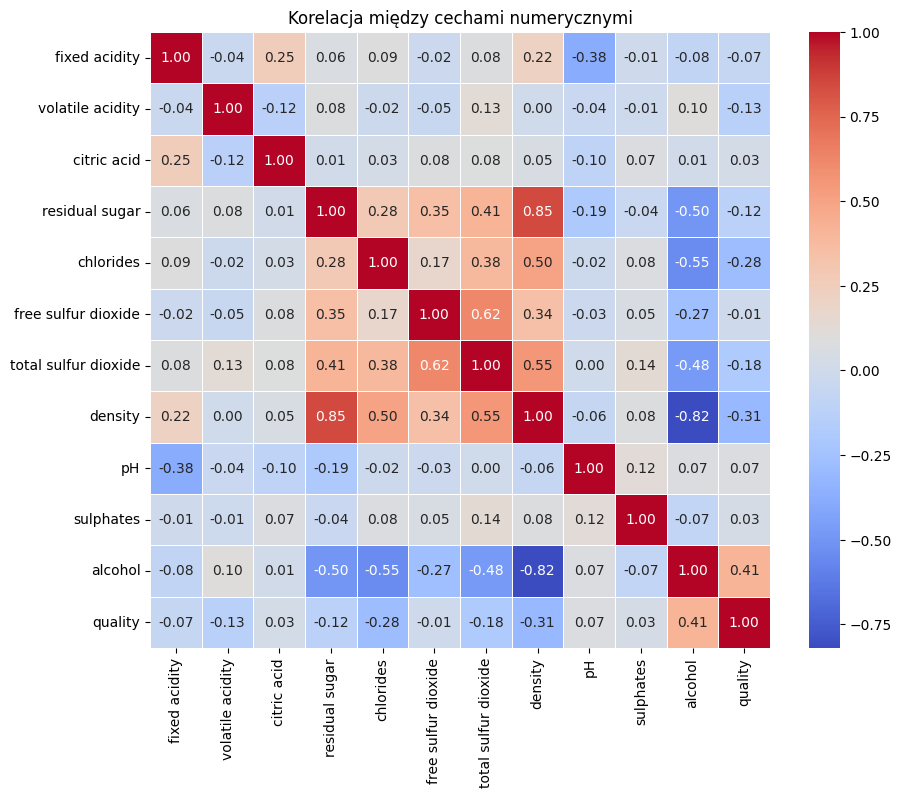

In [56]:
corr = data_cleaned.corr()

# Generowanie heatmapy korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Korelacja między cechami numerycznymi')
plt.show()

Ranking cech z korelacjami

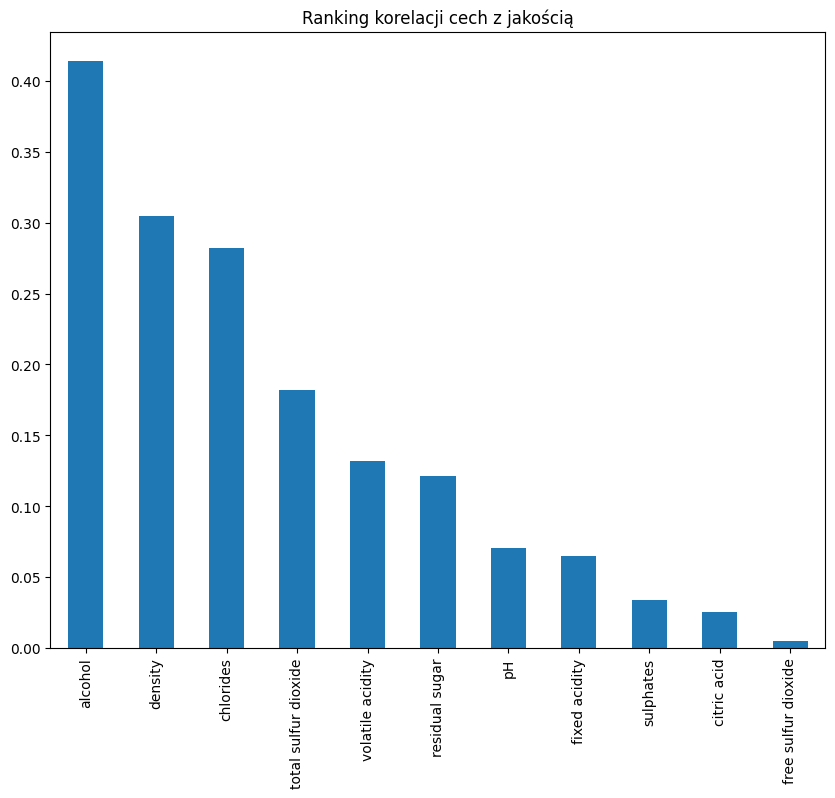

Pozostałe cechy: Index(['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')


In [64]:
# Obliczenie korelacji wszystkich cech z cechą 'quality'
corr_with_quality = data_cleaned.corr()['quality'].drop('quality').abs()

# Ranking korelacji i wyświetlenie go na wykresie słupkowym
corr_with_quality_sorted = corr_with_quality.sort_values(ascending=False)
corr_with_quality_sorted.plot.bar(figsize=(10, 8))
plt.title('Ranking korelacji cech z jakością')
plt.show()

# Usunięcie 2 cech najmniej skorelowanych
# Znalezienie nazw dwóch ostatnich cech w posortowanym DataFrame
features_to_drop = corr_with_quality_sorted.nsmallest(2).index

# Utworzenie nowego DataFrame bez dwóch najmniej skorelowanych cech
data_cleaned_reduced = data_cleaned.drop(columns=features_to_drop)

# Wyświetlenie pozostałych cech
print("Pozostałe cechy:", data_cleaned_reduced.columns)

In [59]:
data_cleaned_reduced = data_cleaned_reduced.dropna()

Analiza głównych składowych

??????????????????????? pod spodem nie jestem pewna

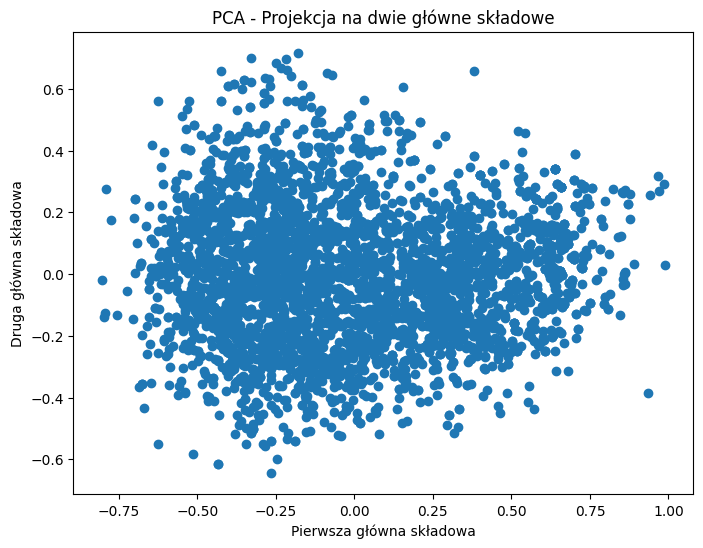

In [65]:
# Wybranie kolumn numerycznych (z wyłączeniem celu)
features = data_cleaned_reduced.columns.difference(['quality']) 

# Wykonanie PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_cleaned_reduced[features])

# Wizualizacja wyników PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Pierwsza główna składowa')
plt.ylabel('Druga główna składowa')
plt.title('PCA - Projekcja na dwie główne składowe')
plt.show()
